# Problématique

<h3> Prédire le mot dans l'image </h3>

- Sample de 1000 observations (1000 mots) : charger (function preprocess (utiliser en sortie un .numpy() pour avoir des arrays), container toutes observations pour faire une matrice de taille (nb_observation, nb_features).
- Modèle Deep learning : RNN
- Évaluation du modèle : ?


# Import

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss


In [37]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)

<module 'ressources' from 'd:\\GitHub\\OCRpyMAN\\notebooks\\ressources.py'>

In [38]:
# BIDOUILLE SALE!! pour importer des fichiers qui ne sont pas dans le meme repertoire. les fichiers devront être mieux rangés par la suite
# import sys
# sys.path.insert(1, '../')

# import preprocessing as pp
# import ressources as rss

# Chargement du dataframe

In [2]:
# initialisation des variables globales
rss.init()

In [16]:
#####TESTSSSS
df = pd.read_pickle('../pickle/df.pickle')

    # on filtre les chaines vides
df['length'] = df['transcription'].apply(lambda x: len(x.strip()))
df = df[df['length'] > 0]

#CLEAN DE JEANPOL
# df['clean_trans'] = df.transcription.apply(lambda x: ld_util.extract_allowed_chars_from_string(rss.charList, x))
# df = df[(df['clean_trans'] != "") & (df['clean_trans'] == df['transcription'])]

#fix temporaire, à finaliser avec l'archi du projet
# df['word_img_path'] = df['word_img_path'].apply(lambda x: x[3:])

X_train, X_test, y_train, y_test = train_test_split(df['word_img_path'], df['transcription'].values, test_size=0.1, random_state=123)
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# dataset = tf.data.Dataset.from_tensor_slices((df['word_img_path'].values, df['transcription'].values))
dataset_train = dataset_train.map(ld_util.process_1_img_canny)

In [19]:
df[df['transcription'] == -1]

,index,word_id,gray_level,x,y,w,h,tag,transcription,word_img_path,...,writer_id,text_id,number_of_sentences,word_seg,total_lines,correct_lines,total_words,correct_words,form_img_path_y,length


In [4]:
#####TESTSSSS
x, y = next(iter(dataset_train))
xx, yy = next(iter(dataset_test))

tmp = x
tmpp = xx
print(x)
# plt.imshow(tmp , cmap='gray')
# plt.ylim([0, 128])
# plt.xlim([0, 32])
print(x.shape)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 176: invalid continuation byte

In [12]:
# Chargement avec tensorflow et dataset par batch

dataset_train, dataset_test, y_test = ld_util.get_dataset()
dataset_train_canny, dataset_test_canny, y_test_canny = ld_util.get_dataset(canny=True)

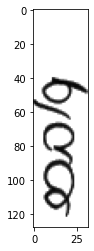

In [8]:
x, y = next(iter(dataset_train_canny))
x[0].shape

tmp = x[0]
# tmp = tf.squeeze(tmp, axis=2)
# tmp = np.swapaxes(tmp, 0, 1)
# tmp = tmp.reshape(128,32)
plt.imshow(tmp , cmap='gray');  # .reshape(rss.img_size)



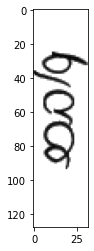

In [11]:
xx, yy = next(iter(dataset_train))
xx[0].shape

tmpp = xx[0]
plt.imshow(tmpp , cmap='gray');  # .reshape(rss.img_size)

# Model RNN

### Création Modèle

In [41]:
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Lambda
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, LeakyReLU, Dropout

model = tf.keras.Sequential()

############
# Layer 1
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='SAME', input_shape = (128, 32, 1)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Layer 2
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Layer 3
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))

# Layer 4
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))

# Layer 5
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))
#####################


# Remove axis 2
model.add(Lambda(lambda x :tf.squeeze(x, axis=2)))
numHidden = 256
# Bidirectionnal RNN
model.add(Bidirectional(GRU(numHidden, return_sequences=True)))
model.add(Dense(100))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 32, 32)       832       
                                                                 
 batch_normalization_15 (Bat  (None, 128, 32, 32)      128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 128, 32, 32)       0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 16, 64)        51264     
                                                                 
 batch_normalization_16 (Bat  (None, 64, 16, 64)      

In [42]:
class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, logits_time_major=False, reduction=tf.keras.losses.Reduction.SUM, name='ctc'):
        super().__init__(reduction=reduction, name=name)
        self.logits_time_major = logits_time_major

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        logit_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        label_length = tf.fill([tf.shape(y_true)[0]], tf.shape(y_true)[1])
        loss = tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=label_length,
            logit_length=logit_length,
            logits_time_major=self.logits_time_major,
            blank_index=-1)
        return tf.reduce_mean(loss)


early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp_model', 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=CTCLoss(), optimizer=optimizer)
history = model.fit(
    dataset_train,
    validation_data=dataset_test,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ],
    epochs=10
)

Epoch 1/10
1285/1285 [==============================] - ETA: 0s - loss: 13.5688

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


1285/1285 [==============================] - 2258s 2s/step - loss: 13.5688 - val_loss: 11.9347
Epoch 2/10
1285/1285 [==============================] - ETA: 0s - loss: 10.8447

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


1285/1285 [==============================] - 1905s 1s/step - loss: 10.8447 - val_loss: 11.2329
Epoch 3/10
1285/1285 [==============================] - ETA: 0s - loss: 9.5762

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


1285/1285 [==============================] - 1795s 1s/step - loss: 9.5762 - val_loss: 9.2284
Epoch 4/10
1285/1285 [==============================] - ETA: 0s - loss: 8.7984

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


1285/1285 [==============================] - 1547s 1s/step - loss: 8.7984 - val_loss: 8.7660
Epoch 5/10
1285/1285 [==============================] - 1456s 1s/step - loss: 8.2637 - val_loss: 9.0664
Epoch 6/10
1285/1285 [==============================] - ETA: 0s - loss: 7.8468

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


1285/1285 [==============================] - 1647s 1s/step - loss: 7.8468 - val_loss: 8.5288
Epoch 7/10
1285/1285 [==============================] - 1792s 1s/step - loss: 7.5247 - val_loss: 8.8260
Epoch 8/10
1285/1285 [==============================] - ETA: 0s - loss: 7.2456

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


1285/1285 [==============================] - 1806s 1s/step - loss: 7.2456 - val_loss: 7.4784
Epoch 9/10
1285/1285 [==============================] - ETA: 0s - loss: 7.0323

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


1285/1285 [==============================] - 1665s 1s/step - loss: 7.0323 - val_loss: 7.2993
Epoch 10/10
1285/1285 [==============================] - 1617s 1s/step - loss: 6.8368 - val_loss: 7.4703


In [58]:
with open('history.pickle', 'wb') as file_pi:
     pickle.dump(history.history, file_pi)

with open('history.pickle', "rb") as file_pi:
    history = pickle.load(file_pi)

In [43]:
x, y = next(iter(dataset_train))
x.shape


TensorShape([64, 128, 32, 1])

In [59]:
y_pred = model.predict(dataset_test)


143/143 [==============================] - 89s 592ms/step


NameError: name 'utils' is not defined

In [72]:
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)
list(zip(predicted_transcriptions, y_test[:10]))

[('on', 'on'),
 ('masaly', 'conveniently'),
 ('it', 'not'),
 ('in', 'in'),
 ('He', 'He'),
 ('of', 'of'),
 (',', ','),
 ('is', 'is'),
 ('pust', 'just'),
 ('in', 'in')]